# IMAGE MOSAIC
#### USING HOMOGRAPHY

In [1]:
%matplotlib notebook
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
from random import randint

In [19]:
def load_images(folder):
    """
    Loads images from given folder.
    Input:
        folder = Folder name
    Output:
        images = List of images.
    """
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
    return images


def find_matches(img1, img2):
    """
    Returns matching image points.
    Input:
        img1 = Image 1
        img2 = Image 2
    Output:
        match_1 = Match points of image 1
        match_2 = Match points of image 2
    """
    
    # Convert images to grayscale
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Initiate SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2,k=2)

    # Filtering best matches
    good = []
    for m,n in matches:
        if m.distance < 0.5*n.distance:
            good.append([m])

    # Matched points
    m1 = []
    m2 = []
    for mat in good:
        img1_idx = mat[0].queryIdx
        img2_idx = mat[0].trainIdx

        # x - columns
        # y - rows
        (x1,y1) = kp1[img1_idx].pt
        (x2,y2) = kp2[img2_idx].pt

        m1.append(kp1[img1_idx].pt)
        m2.append(kp2[img2_idx].pt)

    match_1 = np.array(m1)
    match_2 = np.array(m2)
    
    return match_1, match_2


def estimate_homography(pts1, pts2):
    """
    Estimates homography using matched images points.
    Input:
        pts1 = Points of image1.
        pts2 = Points of image2.
    Output:
        H = Homography matrix.
    """
    pts1_homo = np.hstack((pts1, np.ones((pts1.shape[0], 1))))
    pts2_homo = np.hstack((pts2, np.ones((pts1.shape[0], 1))))

    A = np.zeros((2 * pts1_homo.shape[0], 9))
    for i in range(pts1_homo.shape[0]):
        A[2 * i] = np.hstack((pts2_homo[i,:], np.zeros((3)), -pts1_homo[i, 0] * pts2_homo[i, :]))
        A[2 * i + 1] = np.hstack((np.zeros((3)), pts2_homo[i,:], -pts1_homo[i, 1] * pts2_homo[i, :]))

    u, s, v = np.linalg.svd(A)
    H = v[-1, :].reshape((3, 3))
    H = H / H[2, 2]
    
    return H


def stitch_images(I1, I2, H):
    """
    Stitch two images I1 and I2 using homography.
    Input:
        I1 = Image 1
        I2 = Image 2
        H = Homography matrix
    Output:
        I_1 = Stitched image
    """
    r = I1.shape[0]
    c = I1.shape[1]
    
    I = np.zeros((I2.shape[0] + 2 * I1.shape[0], I2.shape[1] + 2 * I1.shape[1], 3), dtype=np.uint8)
    I[I1.shape[0]:I1.shape[0] + I2.shape[0], I1.shape[1]:I1.shape[1]+I2.shape[1], :] = I2
    I = I.astype(int)
    
    # i = 0
    for row_idx in range(I.shape[0]):
        for col_idx in range(I.shape[1]):
            x = H @ np.array([[col_idx - c, row_idx - r, 1]]).T
            x = np.floor(x / x[2]).astype(int)
            if (0 <= x[1] and x[1] <= (r - 1) and 0 <= x[0] and x[0] <= c - 1):
                I[row_idx, col_idx, :] = I1[x[1], x[0], :]

    # Crop out blackened region
    I_gray = np.sum(I.astype(int), axis=2) / 3
    axis = np.array(np.where(I_gray != 0)).T
    minR = np.min(axis[:, 0])
    maxR = np.max(axis[:, 0])
    minC = np.min(axis[:, 1])
    maxC = np.max(axis[:, 1])
    I_1 = np.uint8(I[minR:maxR, minC:maxC])
    
    return I_1

<IPython.core.display.Javascript object>


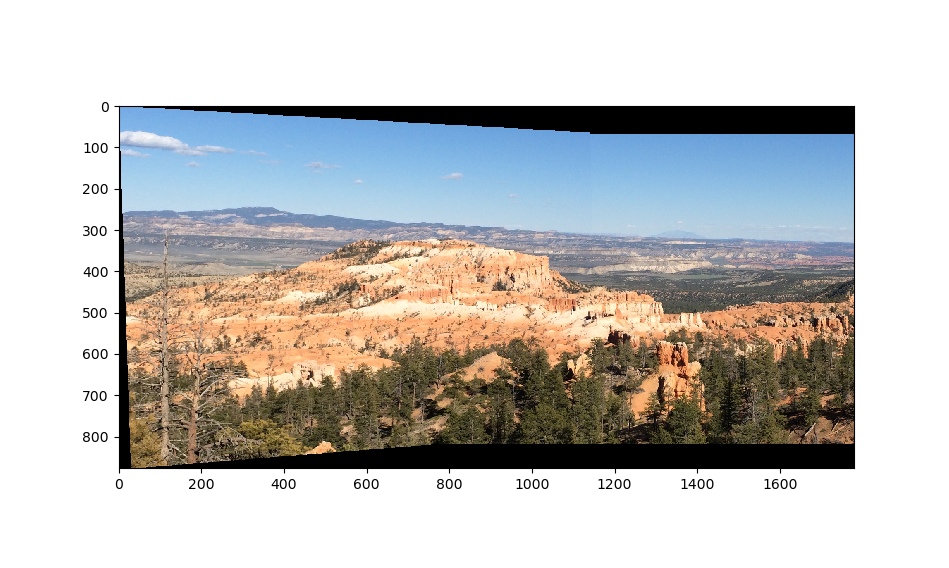

In [3]:
# Load input images
folder = "./images/1"
in_images = load_images(folder)

# Stitching
I2 = in_images[1]
for i in range(1, len(in_images) + 1):
    I1 = in_images[i - 1]
    
    # Finding matches between the two images
    pts1, pts2 = find_matches(I1, I2)
    
    H = estimate_homography(pts1, pts2)
    
    I2 = stitch_images(I1, I2, H)
    
plt.figure()
plt.imshow(I2)
plt.show()

<IPython.core.display.Javascript object>


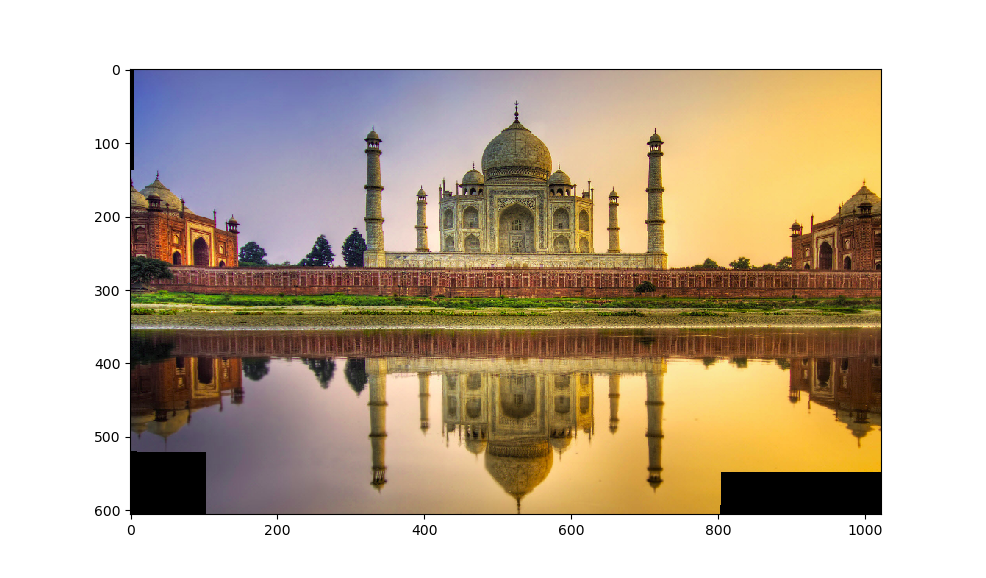

In [8]:
# Load input images
folder = "./images/2"
in_images = load_images(folder)

# Iterative stitching
I2 = in_images[1]
for i in range(1, len(in_images)+1):
    I1 = in_images[i - 1]
    
    # Finding matches between the two images
    pts1, pts2 = find_matches(I1, I2)
    
    H = estimate_homography(pts1, pts2)
    
    I2 = stitch_images(I1, I2, H)
    
plt.figure()
plt.imshow(I2)
plt.show()

<IPython.core.display.Javascript object>


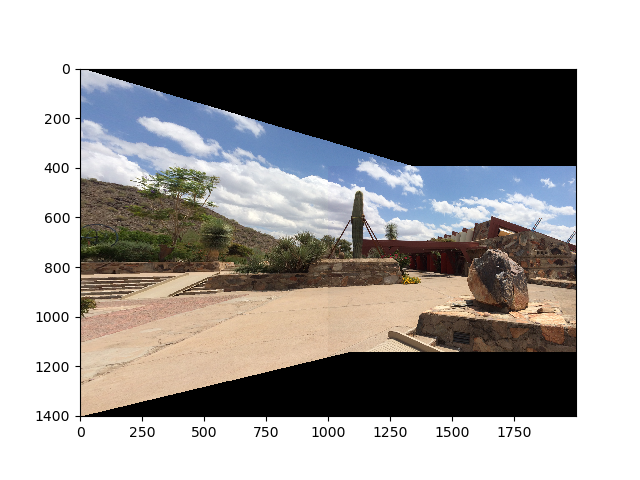

In [20]:
# Load input images
folder = "./images/3"
in_images = load_images(folder)

# Iterative stitching
I2 = in_images[1]
for i in range(1, len(in_images)+1):
    I1 = in_images[i - 1]
    
    # Finding matches between the two images
    pts1, pts2 = find_matches(I1, I2)
    
    H = estimate_homography(pts1, pts2)
    
    I2 = stitch_images(I1, I2, H)
    
plt.figure()
plt.imshow(I2)
plt.show()

2